In [21]:
import MDAnalysis as mda
import nglview as nv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import copy
import math
from tqdm import tqdm_notebook as tqdm

In [2]:
def find_ss_from_pdb(infile,dsspcode='H'):
    output = subprocess.check_output(['mkdssp', infile])
    out_string=output.decode("utf-8") 
    lsw=False
    new_helix=False

    ss_dict = {} # Dicionnary of secondary structures
    for line in out_string.splitlines():
        #print(line)
        if line.find("#  RESIDUE") > 0:
            lsw=True
            continue
        if lsw:
            chainId=line[11]
            if chainId==' ':
                continue
            resn=int(line[5:10])
            seco=line[16]
            if not (chainId in ss_dict):
                ss_dict[chainId]={}
                helix_id=-1
            if seco==dsspcode and not(new_helix):
                #print(line)
                helix_id+=1
                ss_dict[chainId][helix_id]=[resn]
                new_helix=True
            elif seco!=dsspcode and new_helix:
                ss_dict[chainId][helix_id].append(resn)
                new_helix=False
    return ss_dict
def dot(v,w):
    x,y,z = v
    X,Y,Z = w
    return x*X + y*Y + z*Z

def cross(a, b):
    c = [a[1]*b[2] - a[2]*b[1],
         a[2]*b[0] - a[0]*b[2],
         a[0]*b[1] - a[1]*b[0]]
    return c

def vec_norm(v):
    x,y,z = v
    return math.sqrt(x*x + y*y + z*z)


def py_ang(v1, v2):
   
    cosang = dot(v1, v2)
    sinang = vec_norm(cross(v1, v2))
    return math.atan2(sinang, cosang)


### Analysing geometric CVs for tetrasomes from Bilocapic unwrapping classes

In [10]:
mol=mda.Universe('/home/_shared/_projects/gmx_template/GMX_system/sys_ref.pdb','/home/_shared/_projects/gmx_template/big_data/sys_md.xtc')
helix_dict=find_ss_from_pdb('/home/_shared/_projects/gmx_template/GMX_system/sys_ref.pdb','H')
helix_dict_mda_selections=copy.deepcopy(helix_dict)
helix_dict_directions=copy.deepcopy(helix_dict)

view=nv.show_mdanalysis(mol)
view.update_cartoon(opacity=0.25, component=0)
view.update_representation(opacity=0.25, repr_index=5)
shape=view.shape
for chain_id, chain_dict in helix_dict.items():
    for helix_id, index_list in chain_dict.items():
        selection=mol.select_atoms('segid %s and resid %d:%d and name CA'%(chain_id,*index_list))
        helix_dict_mda_selections[chain_id][helix_id]=selection
        roughth_vec=selection.positions[-1]-selection.positions[0]
        direction=selection.principal_axes()[2]
        #reorient if vector is in counter to ca(start)-ca(stop) vec
        if py_ang(roughth_vec,direction) > 1.5: # ~90 degrees in rad
            direction=-direction
        center=selection.center_of_geometry()
        helix_dict_directions[chain_id][helix_id]=[direction,center]
        
        length=(index_list[1]-index_list[0])*1.5
        start=center-direction*length/2
        stop=center+direction*length/2
        shape.add_sphere(center.tolist(),[1,0,0],1)
        shape.add_label(center.tolist(),[0,0,0],5,'Chain %s,%d'%(chain_id,helix_id))
        shape.add_arrow(start.tolist(),stop.tolist(),[0,1,1],1)
view


/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:195: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/MDAnalysis/coordinates/XDR.py:212: UserWarning: Couldn't save offsets because: [Errno 13] Permission denied: '/home/_shared/_projects/gmx_template/big_data/.sys_md.xtc_offsets.npz'
  warnings.warn("Couldn't save offsets because: {}".format(e))


NGLWidget(count=1123)

In [ ]:
angles_df_nucl = pd.DataFrame(columns=['H3-H4-1 angle','DNA H3-H4-1 angle','DNA H3-H4-1 torsion'])
selections={'A':helix_dict_mda_selections['A'][2],
            'B':helix_dict_mda_selections['B'][1]}

n1n9_select_str=' ((resname DA DG ADE GUA and name N9) or (resname DC DT CYT THY and name N1))'

for ts in tqdm(mol.trajectory):
    centers={}
    vectors={}
    for chainID, selection in selections.items():
        centers[chainID]=selection.center_of_geometry()
        roughth_vec=selection.positions[-1]-selection.positions[0]
        direction=selection.principal_axes()[2]
        if py_ang(roughth_vec,direction) > 1.5: # ~90 degrees in rad
                direction=-direction
        vectors[chainID]=direction

    angle_h3_h4_A=np.rad2deg(py_ang(vectors['A'],vectors['B']))
    
    curvature_points={}
    for pos in [-25,-20,-15,-10,-5]:
        curvature_points[pos]={}
        curvature_points[pos]['sel']=mol.select_atoms('((segid I and resnum %d) or (segid J and resnum  %d)) and %s'%(pos,-pos,n1n9_select_str))
        curvature_points[pos]['coord']=np.average(curvature_points[pos]['sel'].positions,axis=0)
    DNA_angle_h3_h4_A=np.rad2deg(mda.lib.distances.calc_angles(curvature_points[-25]['coord'],curvature_points[-15]['coord'],
                                                               curvature_points[-5]['coord']))
   
    
    DNA_dihe_A=np.rad2deg(mda.lib.distances.calc_dihedrals(curvature_points[-25]['coord'],curvature_points[-20]['coord'],
                                                           curvature_points[-10]['coord'],curvature_points[-5]['coord']))
    
    angles_df_nucl.loc[ts.time] =[angle_h3_h4_A, DNA_angle_h3_h4_A,DNA_dihe_A]
angles_df_nucl.to_csv('Results/GeometricCV_freeMD_native_h3_h4_dimer.csv')


In [13]:
angles_df_nucl_native=angles_df_nucl.copy()

### Analysing geometric CVs for tetrasomes from Bilocapic translocation classes

In [14]:
mol=mda.Universe('/home/_shared/_projects/2018_h3-h4_mut_dyn/h3-h4_tm_mut_30_DNA_MD/GMX_system/sys_ref_renamed.pdb','/home/_shared/_projects/2018_h3-h4_mut_dyn/h3-h4_tm_mut_30_DNA_MD/big_data/sys_md.xtc')
helix_dict=find_ss_from_pdb('/home/_shared/_projects/2018_h3-h4_mut_dyn/h3-h4_tm_mut_30_DNA_MD/GMX_system/sys_ref_renamed.pdb','H')
helix_dict_mda_selections=copy.deepcopy(helix_dict)
helix_dict_directions=copy.deepcopy(helix_dict)

view=nv.show_mdanalysis(mol)
view.update_cartoon(opacity=0.25, component=0)
view.update_representation(opacity=0.25, repr_index=5)
shape=view.shape
for chain_id, chain_dict in helix_dict.items():
    for helix_id, index_list in chain_dict.items():
        selection=mol.select_atoms('segid %s and resid %d:%d and name CA'%(chain_id,*index_list))
        helix_dict_mda_selections[chain_id][helix_id]=selection
        roughth_vec=selection.positions[-1]-selection.positions[0]
        direction=selection.principal_axes()[2]
        #reorient if vector is in counter to ca(start)-ca(stop) vec
        if py_ang(roughth_vec,direction) > 1.5: # ~90 degrees in rad
            direction=-direction
        center=selection.center_of_geometry()
        helix_dict_directions[chain_id][helix_id]=[direction,center]
        
        length=(index_list[1]-index_list[0])*1.5
        start=center-direction*length/2
        stop=center+direction*length/2
        shape.add_sphere(center.tolist(),[1,0,0],1)
        shape.add_label(center.tolist(),[0,0,0],5,'Chain %s,%d'%(chain_id,helix_id))
        shape.add_arrow(start.tolist(),stop.tolist(),[0,1,1],1)
view

NGLWidget(count=2264)

In [ ]:
angles_df_nucl = pd.DataFrame(columns=['H3-H4-1 angle','DNA H3-H4-1 angle','DNA H3-H4-1 torsion'])
selections={'A':helix_dict_mda_selections['A'][2],
            'B':helix_dict_mda_selections['B'][1]}

n1n9_select_str=' ((resname DA DG ADE GUA and name N9) or (resname DC DT CYT THY and name N1))'

for ts in tqdm(mol.trajectory):
    centers={}
    vectors={}
    for chainID, selection in selections.items():
        centers[chainID]=selection.center_of_geometry()
        roughth_vec=selection.positions[-1]-selection.positions[0]
        direction=selection.principal_axes()[2]
        if py_ang(roughth_vec,direction) > 1.5: # ~90 degrees in rad
                direction=-direction
        vectors[chainID]=direction

    angle_h3_h4_A=np.rad2deg(py_ang(vectors['A'],vectors['B']))
    
    curvature_points={}
    for pos in [-25,-20,-15,-10,-5]:
        curvature_points[pos]={}
        curvature_points[pos]['sel']=mol.select_atoms('((segid I and resnum %d) or (segid J and resnum  %d)) and %s'%(pos,-pos,n1n9_select_str))
        curvature_points[pos]['coord']=np.average(curvature_points[pos]['sel'].positions,axis=0)
    DNA_angle_h3_h4_A=np.rad2deg(mda.lib.distances.calc_angles(curvature_points[-25]['coord'],curvature_points[-15]['coord'],
                                                               curvature_points[-5]['coord']))
   
    
    DNA_dihe_A=np.rad2deg(mda.lib.distances.calc_dihedrals(curvature_points[-25]['coord'],curvature_points[-20]['coord'],
                                                           curvature_points[-10]['coord'],curvature_points[-5]['coord']))
    
    angles_df_nucl.loc[ts.time] =[angle_h3_h4_A, DNA_angle_h3_h4_A,DNA_dihe_A]
angles_df_nucl.to_csv('Results/GeometricCV_freeMD_cross_h3_h4_dimer.csv')
angles_df_nucl

In [23]:
angles_df_nucl_cross=angles_df_nucl.copy()
angles_df_nucl_cross

,H3-H4-1 angle,DNA H3-H4-1 angle,DNA H3-H4-1 torsion
0.0,140.788606,131.667163,-6.618267
1000.0,139.126450,125.198086,-23.390039
2000.0,142.464474,129.064504,-4.975623
3000.0,141.831838,127.129059,-25.338238
4000.0,139.579937,129.256735,1.484712
5000.0,138.986453,129.888408,-12.573579
6000.0,138.219138,125.624607,-15.162181
7000.0,138.891081,127.628375,-13.888672
8000.0,139.841877,125.983007,-3.805830
9000.0,139.631611,120.906492,-11.890981


/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  
/opt/miniconda3/envs/moldyn/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Passing `normed=True` on 

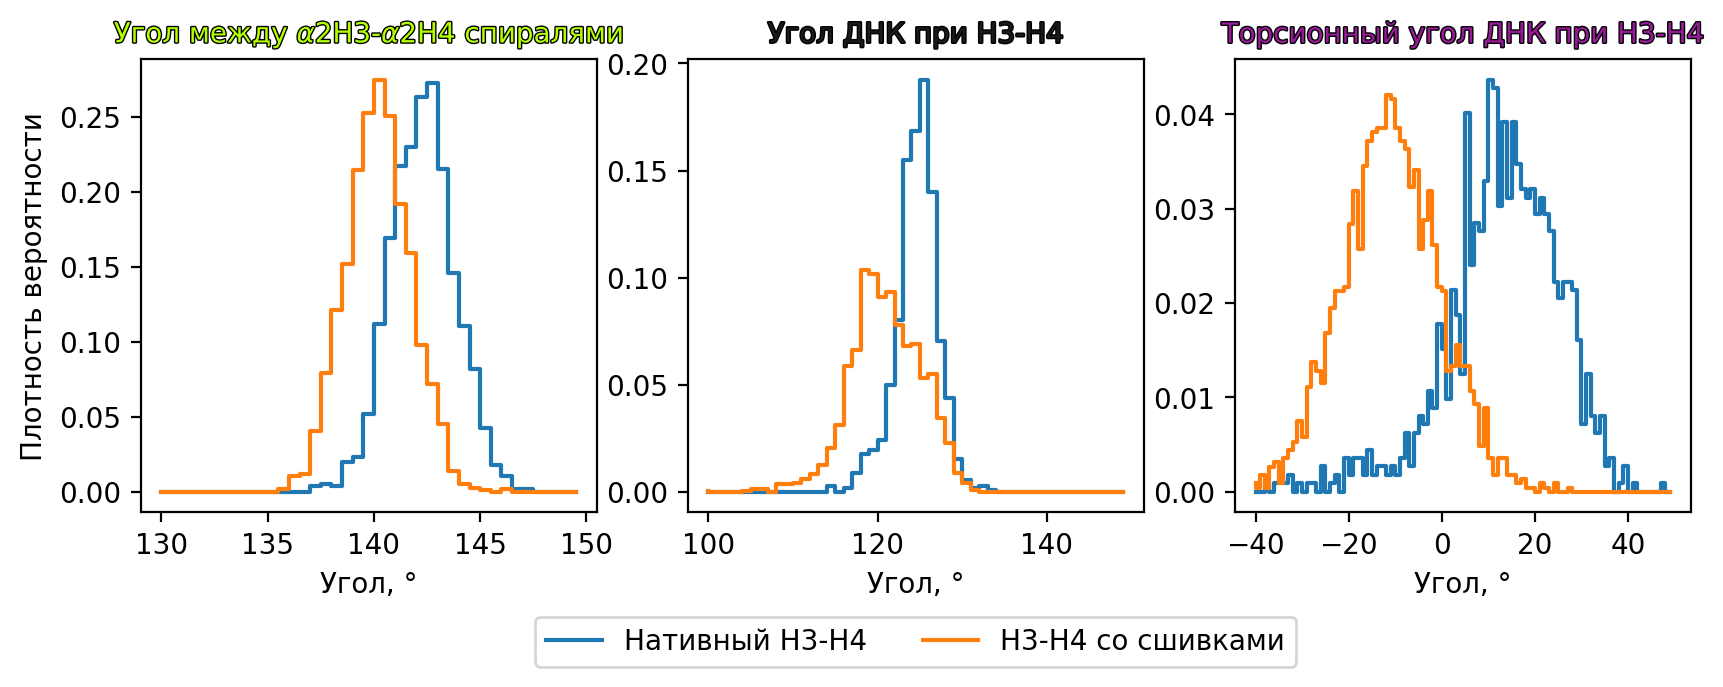

In [34]:
import matplotlib.patheffects as path_effects

fig,ax=plt.subplots(1,3,figsize=(10,3),dpi=200)
#'H3-H4-1 angle','DNA H3-H4-1 angle','DNA H3-H4-1 torsion'
native_angle=np.histogram(angles_df_nucl_native['H3-H4-1 angle'],bins=40,range=(130,150),normed=True)
native_DNA_tors=np.histogram(angles_df_nucl_native['DNA H3-H4-1 angle'],bins=50,range=(100,150),normed=True)
native_DNA_angle=np.histogram(angles_df_nucl_native['DNA H3-H4-1 torsion'],bins=90,range=(-40,50),normed=True)

cross_angle=np.histogram(angles_df_nucl_cross['H3-H4-1 angle'],bins=40,range=(130,150),normed=True)
cross_DNA_tors=np.histogram(angles_df_nucl_cross['DNA H3-H4-1 angle'],bins=50,range=(100,150),normed=True)
cross_DNA_angle=np.histogram(angles_df_nucl_cross['DNA H3-H4-1 torsion'],bins=90,range=(-40,50),normed=True)


ax[0].set_title(r'Угол между $\alpha 2$H3-$\alpha 2$H4 спиралями',color=[0.7,1,0.0],size=10,path_effects=[path_effects.Stroke(linewidth=1, foreground='black'),
                                                                    path_effects.Normal()])
#ax[0].axvline(x=74.258,color='k')
ax[0].step(native_angle[1][:-1],native_angle[0])
ax[0].step(cross_angle[1][:-1],cross_angle[0])
ax[0].set_xlabel(u'Угол, °')
ax[0].set_ylabel(u'Плотность вероятности')

ax[1].set_title(r'Угол ДНК при H3-H4',color=[0.1,0.1,0.1],size=10,path_effects=[path_effects.Stroke(linewidth=1, foreground='black'),
                                                                    path_effects.Normal()])
#ax[1].axvline(x=-111.287,color='k',label='Crystal structure')
ax[1].step(native_DNA_tors[1][:-1],native_DNA_tors[0],label=u'Нативный H3-H4')
ax[1].step(cross_DNA_tors[1][:-1],cross_DNA_tors[0],label=u'H3-H4 со сшивками')
ax[1].set_xlabel(u'Угол, °')

ax[2].set_title(r'Торсионный угол ДНК при H3-H4',color=[0.6,0.1,0.6],size=10,path_effects=[path_effects.Stroke(linewidth=1, foreground='black'),
                                                                    path_effects.Normal()])
#ax[2].axvline(x=-12.231,color='k')
#ax[2].step([],[])
ax[2].step(native_DNA_angle[1][:-1],native_DNA_angle[0])
ax[2].step(cross_DNA_angle[1][:-1],cross_DNA_angle[0])
ax[2].set_xlabel(u'Угол, °')

#ax
#'H3-H3 angle','Tetramer torsion','DNA torsion'
#angles_df.hist(ax=ax,bins=50,)
#plt.show()
#fig,ax=plt.subplots(1,3,figsize=(9,3))
#angles_df_nucl.hist(ax=ax,bins=50,)
#plt.show()
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)
#ax[1].legend()

plt.savefig('Results/geometric_CV_traj.png',dpi=300,bbox_inches = 'tight')
plt.show()